## Assessing Toronto's Neighborhood to Open Chinese Restaurant

### 1. Introduction and  Business Problem Description

#### 1.1 Background
Toronto, the capital of Ontario province , is the most populated, multicultural and multiracial Canadian city. Its diversity reflected in  Toronto's ethnic neighbourhoods such as Chinatown, Corso Italia, Little Italy, Little India, Greektown, Koreatown, Little Jamaica, Little Portugal and Roncesvalles, which celebrate the city's multiculturalism.  It is one of the most immigrant-friendly cities in North America with estimated  population of just above 2.8 Million with a population density of 4,149.5 people per square kilometer (10,750/sq mi) in 2016, inwhich  the chinese community has take the share of 12%. Hence,Opening Chinese Restaurant in Toronto can be a profitable business worth investing in.

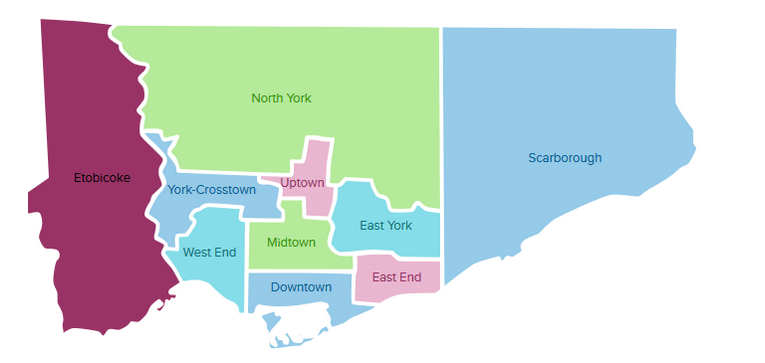


#### 1.2  Business Problem Description
It is known that Toronto shelters a greater number of Chinese and/or Chinese ancestry Canadian than any other city in Canada, it is a good idea to start the restaurant here, but we just need to make sure whether it is a profitable business or not. If so, where it can be located to yield more profit to the investor. Since there are lots of  Chinese restaurants in  Toronto we need to find  **locations with no Chinese restaurant in the vicinity  or areas which are not already crowded with Chinese restaurants**. 

Chinese population demography and existing Chinese restaurants across the neighborhoods are used as an input for identifying the most profitable location, since the success of the restaurant depends on the  potential people(targeted customers) and ambience. 

### 2. Data Acquisition and Cleaning
#### 2.1 Data Sources
The following data sources are  collectively used to solve the above stated problem

I) Wikipedia page:  “List of Postal code of Canada: M" (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) to get Toronto's neighborhoods information. This page has the postal code, borough and the name of all the neighborhoods in Toronto.

II) Cvs file: “https://cocl.us/Geospatial_data” to get  the geographical coordinates of the neighborhoods.

III) Wikipedia page sources Csv file:  “Demographics of Toronto” (https://en.m.wikipedia.org/wiki/Demographics_of_Toronto#Ethnic_diversity) to get information about the distribution of population by their ethnicity. Using this page I’m going to identify the neighborhoods which are densely populated with chinese community as it might be helpful in identifying the suitable neighborhood to open a new chinese restaurant.

IV) Foursquare’s API (https://developer.foursquare.com/docs): To get location and other information about various Chinese venues in Toronto. Using the Foursquare’s explore API (which gives venues recommendations), I’m fetching details about the venues up present in Toronto and collected their names, categories and locations (latitude and longitude).

   

#### 2.2 Data Acquisation and Cleaning

The following libraries are installed  for pulling, preparing, analyzing and visualizing the data.

In [1]:
!pip install beautifulsoup4
!pip install lxml
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import random # library for random number generation

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML
from IPython.display import display_html

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')
print('folium installed.')

     |████████████████████████████████| 102kB 19.4MB/s ta 0:00:01
     |████████████████████████████████| 5.8MB 31.1MB/s eta 0:00:01
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    numpy-1.17.3       

##### **I)  Toronto's Postal Code, Borough and Neighborhood**

In [2]:
##  Postal code, Borough and Neighborhood Data acuisation from wikipedia page
Data = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
BS=BeautifulSoup(Data,'lxml')
print(BS.title)


<title>List of postal codes of Canada: M - Wikipedia</title>


In [3]:
table = BS.find('table',{'class':'wikitable sortable'})

##### Change the Html table to Panda DataFrame

In [4]:
table_rows = table.find_all('tr')  # to read table rows

In [5]:
dataset = []
for row in table_rows:
    dataset.append([t.text.strip() for t in row.find_all('td')])

df = pd.DataFrame(dataset, columns=['PostalCode', 'Borough', 'Neighbourhood'])
df = df[~df['PostalCode'].isnull()]  # to filter out bad rows
print(df.head())

  PostalCode           Borough     Neighbourhood
1        M1A      Not assigned      Not assigned
2        M2A      Not assigned      Not assigned
3        M3A        North York         Parkwoods
4        M4A        North York  Victoria Village
5        M5A  Downtown Toronto      Harbourfront


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 1 to 287
Data columns (total 3 columns):
PostalCode       287 non-null object
Borough          287 non-null object
Neighbourhood    287 non-null object
dtypes: object(3)
memory usage: 9.0+ KB


In [7]:
#To Ignore "Not assigned" cells from "Borough" column 
df.drop(df[df['Borough']=="Not assigned"].index,axis=0, inplace=True) 
df.reset_index (drop=True,inplace=True)
df.head()


,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [8]:
df.shape

(210, 3)

##### Combining the Neighborhoods name having the same "PostalCode" and "Borough"

In [9]:
df1=df.groupby(['PostalCode','Borough'], sort=False).agg(', '.join)
df1.reset_index(inplace=True)
df1.head()

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Not assigned


In [10]:
df1.shape

(103, 3)

##### Replacing the name of the Neighborhoods which are 'Not assigned' with names of 'Borough'

In [11]:
df1['Neighbourhood'] = np.where(df1['Neighbourhood'] == 'Not assigned',df1['Borough'], df1['Neighbourhood'])
df1.head()

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


In [12]:
df1.shape

(103, 3)

##### **II) Lattitud and Longtiude data of Toronto's Neighborhoods**

In [13]:
# Latitude and Longitude of Toronto's Neighborhoof is find from "http://cocl.us/Geospatial_data"
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lon.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [14]:
lat_lon.shape

(103, 3)

##### **Merging df1 and lat_long tables to create a new table df2 with PostalCode, borough, neighborhood,Latitude and Longitude**

In [15]:
lat_lon.rename(columns={'Postal Code':'PostalCode'}, inplace=True) #similirize the 'PostalCode' column name
df2= pd.merge(df1,lat_lon,on='PostalCode')
df2.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


##### **III) Toronto's neighborhood Population by their ethnicity**

Extracted from: 
Wiki page : "https://en.m.wikipedia.org/wiki/Demographics_of_Toronto#Ethnic_diversity"  
and  
Toronto Census data: "https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#8c732154-5012-9afe-d0cd-ba3ffc813d5a"  
and then prepared the csv file called 'Toronto_Ethnic_pop.csv'   

In [16]:
df_pop = pd.read_csv('Toronto_Ethnic_Pop.csv') # load the census data
df_pop.head()

,PostalCode,Borough,Neighbourhood Number,"Population, 2016",Population density per square kilometre,Land area in square kilometres,South Asian,Chinese,Black,Filipino,Latin American,Arab,Southeast Asian,West Asian,Korean,Japanese,White
0,M1B,Scarborough,263,90290,6208,45.74,41.64,6.00,16.49,9.92,1.41,0.84,0.55,1.32,0.16,0.15,14.64
1,M1C,Scarborough,134,12494,2403,5.20,36.14,7.64,12.41,6.44,1.64,0.68,0.68,0.80,1.04,0.28,25.49
2,M1E,Scarborough,411,54764,8570,19.04,18.74,3.44,15.05,8.04,1.74,0.50,0.90,1.29,0.37,0.53,43.03
3,M1G,Scarborough,137,53485,4345,12.31,40.28,6.95,10.91,7.65,1.39,1.14,0.59,2.47,0.39,0.19,23.36
4,M1H,Scarborough,127,29960,4011,7.47,27.72,14.69,6.38,9.63,1.77,1.12,1.03,2.72,0.68,0.52,26.77


In [17]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 17 columns):
PostalCode                                 88 non-null object
Borough                                    88 non-null object
Neighbourhood Number                       88 non-null int64
Population, 2016                           88 non-null int64
Population density per square kilometre    88 non-null int64
Land area in square kilometres             88 non-null float64
South Asian                                88 non-null float64
Chinese                                    88 non-null float64
Black                                      88 non-null float64
Filipino                                   88 non-null float64
Latin American                             88 non-null float64
Arab                                       88 non-null float64
Southeast Asian                            88 non-null float64
West Asian                                 88 non-null float64
Korean                 

#### Combining df2 and df_pop data frames and create a new data frame df3

In [18]:
PostalCode = []
Borough=[]
Neighbourhood=[]
Population=[]
Latitude = []
Longitude = []
P_density = []
L_Area = []
South_Asian = []
Chinese = []
Black = []
Filipino = []
Latin_American = []
Arab = []
Southeast_Asian =[]
West_Asian = []
Korean = []
Japanese = []
White = []

for i in df2['PostalCode']:
    if df_pop['PostalCode'].isin([i]).any():
        PostalCode.append(i)
        loc = df2.index[df2['PostalCode']==i]
        Borough.append(df2['Borough'][loc].values[0])
        Neighbourhood.append(df2['Neighbourhood'][loc].values[0])
        Latitude.append(df2['Latitude'][loc].values[0])
        Longitude.append(df2['Longitude'][loc].values[0])
        loc = df_pop.index[df_pop['PostalCode']==i]
        Population.append(df_pop['Population, 2016'][loc].values[0])
        P_density.append(df_pop['Population density per square kilometre'][loc].values[0])
        L_Area.append(df_pop['Land area in square kilometres'][loc].values[0])
        South_Asian.append(df_pop['South Asian'][loc].values[0])
        Chinese.append(df_pop['Chinese'][loc].values[0])
        Black.append(df_pop['Black'][loc].values[0])
        Filipino.append(df_pop['Filipino'][loc].values[0])
        Latin_American.append(df_pop['Latin American'][loc].values[0])
        Arab.append(df_pop['Arab'][loc].values[0])
        Southeast_Asian.append(df_pop['Southeast Asian'][loc].values[0])
        West_Asian.append(df_pop['West Asian'][loc].values[0])
        Korean.append(df_pop['Korean'][loc].values[0])
        Japanese.append(df_pop['Japanese'][loc].values[0])
        White.append(df_pop['White'][loc].values[0])
        

In [19]:
df3 = pd.DataFrame({'PostalCode':PostalCode,'Borough':Borough,'Neighbourhood':Neighbourhood,'Latitude':Latitude,
                        'Longitude':Longitude,'Population':Population,'Density':P_density,'L_Area':L_Area,'South Asian':South_Asian,
                       'Chinese':Chinese,'Black':Black,'Filipino':Filipino,'Latin American':Latin_American,
                       'Arab':Arab,'Southeast Asian':Southeast_Asian,'West Asian':West_Asian,'Korean':Korean,
                       'Japanese':Japanese,'White':White})
df3.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Population,Density,L_Area,South Asian,Chinese,Black,Filipino,Latin American,Arab,Southeast Asian,West Asian,Korean,Japanese,White
0,M3A,North York,Parkwoods,43.753259,-79.329656,34805,4691,7.42,10.37,8.26,11.23,7.00,2.94,4.35,0.56,4.60,1.67,0.65,44.98
1,M4A,North York,Victoria Village,43.725882,-79.315572,17510,3710,4.72,17.05,4.17,11.85,7.08,2.46,6.11,0.54,4.11,0.91,0.43,40.18
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,76716,25823,8.01,17.93,13.09,9.55,2.46,2.39,2.25,2.32,1.80,1.15,0.56,42.69
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,6577,3614,1.82,5.02,1.67,31.47,6.01,5.09,1.06,3.27,0.15,0.23,0.00,39.68
4,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,90290,6208,45.74,41.64,6.00,16.49,9.92,1.41,0.84,0.55,1.32,0.16,0.15,14.64


##### **IV) Foursquare’s API  for identifing Venues in Toronto's Neighborhoods**

In [20]:
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          91 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0   conda-forge
    geopy:         1.20.0-py_0 conda-forge


geopy-1.20.0         | 57 KB     | ##################################### | 100% 
geographiclib-1.50   | 3

In [21]:
# finding Latitude and Longitude of Toronto, CA for Folium map
address = 'Toronto, CA'
geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


 ##### **Creating Folium Map to visualize different neighborhood of Toronto**

In [22]:
# create map of Tronto using latitude and longitude values
Toronto_map = folium.Map(location=[43.653963,-79.387207],zoom_start=12)

for lat,lng,borough,neighbourhood in zip(df3['Latitude'],df3['Longitude'],df3['Borough'],df3['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.8,
    parse_html=False).add_to(Toronto_map)
Toronto_map


In [23]:
CLIENT_ID = '324QO4TQBUYC5RO2FSP00DP0LBN4NP45ZKXKH0RRLW5SIIY0' # my Foursquare ID
CLIENT_SECRET = 'IVD4TSXZ1OKVEJNVSJZUVBF5PYVIIHIWJWCNRFJUAW2OBVTG' # my Foursquare Secret
VERSION = '20180604'
LIMIT=200
search_query = 'Chinese'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 324QO4TQBUYC5RO2FSP00DP0LBN4NP45ZKXKH0RRLW5SIIY0
CLIENT_SECRET:IVD4TSXZ1OKVEJNVSJZUVBF5PYVIIHIWJWCNRFJUAW2OBVTG


#### Searching 200 chinese venues using Foursquear API. So, let's define a query to search for Chinese restaurant that is within 5000 metres from the city center. 


In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
venues = getNearbyVenues(names=df3['Neighbourhood'],
                                   latitudes=df3['Latitude'],
                                   longitudes=df3['Longitude']
                                 )

Parkwoods
Victoria Village
Harbourfront
Lawrence Heights, Lawrence Manor
Rouge, Malvern
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Highland Creek, Rouge Hill, Port Union
Flemingdon Park, Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Guildwood, Morningside, West Hill
The Beaches
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Cedarbrae
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Thorncliffe Park
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
CFB Toronto, Downsview East
The Danforth West, Riverdale
Design Exchange, Toronto Dominion Centre
Brockton,

In [26]:
print(venues.shape)
venues.head()

(8668, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,Graydon Hall Manor,43.763923,-79.342961,Event Space
2,Parkwoods,43.753259,-79.329656,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course
3,Parkwoods,43.753259,-79.329656,Galleria Supermarket,43.753520,-79.349518,Supermarket
4,Parkwoods,43.753259,-79.329656,LA Fitness,43.747665,-79.347077,Gym / Fitness Center


In [27]:
venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,100,100,100,100,100,100
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",100,100,100,100,100,100
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",83,83,83,83,83,83
"Alderwood, Long Branch",100,100,100,100,100,100
"Bathurst Manor, Downsview North, Wilson Heights",100,100,100,100,100,100
Bayview Village,100,100,100,100,100,100
"Bedford Park, Lawrence Manor East",100,100,100,100,100,100
"Birch Cliff, Cliffside West",100,100,100,100,100,100


In [28]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 253 uniques categories.


##### One hot encode the unique categories

In [29]:
# one hot encoding
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
venues_onehot['Neighbourhood'] = venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,Neighbourhood,ATM,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Campground,Cantonese Restaurant,Caribbean Restaurant,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Liquor Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [30]:
venues_onehot.shape

(8668, 254)

In [31]:
venues_grouped = venues_onehot.groupby('Neighbourhood').sum().reset_index()
venues_grouped

,Neighbourhood,ATM,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Campground,Cantonese Restaurant,Caribbean Restaurant,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Liquor Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Adelaide, King, Richmond",0,0,0,0,1,0,0,1,2,1,0,0,0,0,0,0,1,0,2,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,1,0,7,0,1,0,1,2,0,0,1,0,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,5,0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,2,1,0,1,1,1,0,0,0,0,0,2,0,0

In [32]:
num_top_venues = 10

for hood in venues_grouped['Neighbourhood']:
    print("----"+hood+"----")
    info = venues_grouped[venues_grouped['Neighbourhood'] == hood].T.reset_index()
    info.columns = ['venue','freq']
    info= info.iloc[1:]
    info['freq'] = info['freq'].astype(float)
    info = info.round({'freq': 2})
    print(info.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')



----Adelaide, King, Richmond----
                           venue  freq
0                    Coffee Shop   7.0
1                           Café   5.0
2                          Hotel   5.0
3                     Restaurant   3.0
4                           Park   3.0
5                 Sandwich Place   3.0
6                    Pizza Place   3.0
7            Japanese Restaurant   3.0
8             Italian Restaurant   3.0
9  Vegetarian / Vegan Restaurant   2.0


----Agincourt----
                  venue  freq
0    Chinese Restaurant  10.0
1  Caribbean Restaurant   5.0
2     Indian Restaurant   5.0
3                Bakery   4.0
4           Coffee Shop   4.0
5           Pizza Place   3.0
6      Hakka Restaurant   3.0
7                  Park   3.0
8           Supermarket   3.0
9          Noodle House   3.0


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                   venue  freq
0     Chinese Restaurant  10.0
1   Caribbean Restaurant   6.0
2                 Bakery   6

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

for ind in np.arange(venues_sorted.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Coffee Shop,Hotel,Café,Restaurant,Pizza Place,Sandwich Place,Japanese Restaurant,Italian Restaurant,Park,Concert Hall
1,0,Chinese Restaurant,Indian Restaurant,Caribbean Restaurant,Bakery,Coffee Shop,Noodle House,Park,Hakka Restaurant,Supermarket,Pizza Place
2,0,Chinese Restaurant,Caribbean Restaurant,Bakery,Indian Restaurant,Vietnamese Restaurant,Breakfast Spot,Japanese Restaurant,Bubble Tea Shop,Supermarket,Noodle House
3,0,Coffee Shop,Fast Food Restaurant,Sandwich Place,Pharmacy,Asian Restaurant,Grocery Store,Chinese Restaurant,Caribbean Restaurant,Italian Restaurant,Bakery
4,0,Burger Joint,Bakery,Coffee Shop,Café,Breakfast Spot,Liquor Store,Grocery Store,Burrito Place,Pizza Place,Seafood Restaurant


In [35]:
venues_grouped.columns.values.tolist()


['Neighbourhood',
 'ATM',
 'Afghan Restaurant',
 'Airport',
 'Airport Lounge',
 'American Restaurant',
 'Amphitheater',
 'Antique Shop',
 'Aquarium',
 'Art Gallery',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auto Dealership',
 'Automotive Shop',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Baseball Stadium',
 'Basketball Court',
 'Basketball Stadium',
 'Beach',
 'Beer Bar',
 'Beer Store',
 'Big Box Store',
 'Bike Shop',
 'Bistro',
 'Bookstore',
 'Botanical Garden',
 'Boutique',
 'Bowling Alley',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bridal Shop',
 'Bridge',
 'Bubble Tea Shop',
 'Buffet',
 'Building',
 'Burger Joint',
 'Burrito Place',
 'Butcher',
 'Café',
 'Camera Store',
 'Campground',
 'Cantonese Restaurant',
 'Caribbean Restaurant',
 'Castle',
 'Caucasian Restaurant',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Circus',
 'Climbing Gym',
 'Clothing Store',
 'Cocktail Bar',
 'Coffee Shop',
 'College Rec C

#### Calculate the total number of restaurante in each region

In [38]:
total_restaurants = venues_grouped['Afghan Restaurant']+venues_grouped['Airport Lounge']+venues_grouped['American Restaurant']+\
venues_grouped['Asian Restaurant']+venues_grouped['BBQ Joint']+\
venues_grouped['Bagel Shop']+venues_grouped['Brazilian Restaurant']+\
venues_grouped['Breakfast Spot']+venues_grouped['Burger Joint']+venues_grouped['Burrito Place']+\
venues_grouped['Cantonese Restaurant']+venues_grouped['Caribbean Restaurant']+venues_grouped['Caucasian Restaurant']+\
venues_grouped['Chinese Restaurant']+venues_grouped['Comfort Food Restaurant']+venues_grouped['Cuban Restaurant']+\
venues_grouped['Deli / Bodega']+venues_grouped['Diner']+venues_grouped['Doner Restaurant']+venues_grouped['Dumpling Restaurant']+\
venues_grouped['Eastern European Restaurant']+venues_grouped['Egyptian Restaurant']+venues_grouped['Ethiopian Restaurant']+\
venues_grouped['Falafel Restaurant']+venues_grouped['Fast Food Restaurant']+venues_grouped['Filipino Restaurant']+\
venues_grouped['Fish & Chips Shop']+venues_grouped['French Restaurant']+venues_grouped['Fried Chicken Joint']+\
venues_grouped['Greek Restaurant']+venues_grouped['Hakka Restaurant']+\
venues_grouped['Hong Kong Restaurant']+venues_grouped['Hotel']+venues_grouped['Hotpot Restaurant']+venues_grouped['Hungarian Restaurant']+\
venues_grouped['Indian Restaurant']+venues_grouped['Indonesian Restaurant']+venues_grouped['Italian Restaurant']+\
venues_grouped['Japanese Restaurant']+venues_grouped['Kebab Restaurant']+venues_grouped['Korean Restaurant']+\
venues_grouped['Latin American Restaurant']+ venues_grouped['Malay Restaurant']+venues_grouped['Mediterranean Restaurant']+\
venues_grouped['Mexican Restaurant']+venues_grouped['Middle Eastern Restaurant']+venues_grouped['New American Restaurant']+\
venues_grouped['Pakistani Restaurant']+venues_grouped['Persian Restaurant']+venues_grouped['Peruvian Restaurant']+\
venues_grouped['Pizza Place']+venues_grouped['Portuguese Restaurant']+\
venues_grouped['Ramen Restaurant']+venues_grouped['Restaurant']+\
venues_grouped['Salad Place']+venues_grouped['Sandwich Place']+\
venues_grouped['Scandinavian Restaurant']+venues_grouped['Seafood Restaurant']+venues_grouped['Snack Place']+\
venues_grouped['South American Restaurant']+venues_grouped['Spanish Restaurant']+venues_grouped['Sri Lankan Restaurant']+\
venues_grouped['Steakhouse']+venues_grouped['Sushi Restaurant']+venues_grouped['Szechuan Restaurant']+\
venues_grouped['Taco Place']+venues_grouped['Taiwanese Restaurant']+venues_grouped['Tapas Restaurant']+venues_grouped['Thai Restaurant']+\
venues_grouped['Theme Restaurant']+venues_grouped['Turkish Restaurant']+venues_grouped['Vegetarian / Vegan Restaurant']+\
venues_grouped['Vietnamese Restaurant']+venues_grouped['Wings Joint']

In [39]:
df_restaurants = pd.DataFrame(data={'Neighbourhood': venues_grouped['Neighbourhood'],'Total Restaurants':total_restaurants,
                                  'Chinese Restaurants':venues_grouped['Chinese Restaurant']})

In [40]:
df_restaurants.head(10)

,Neighbourhood,Total Restaurants,Chinese Restaurants
0,"Adelaide, King, Richmond",37,0
1,Agincourt,64,10
2,"Agincourt North, L'Amoreaux East, Milliken, St...",59,10
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",45,3
4,"Alderwood, Long Branch",41,0
5,"Bathurst Manor, Downsview North, Wilson Heights",35,0
6,Bayview Village,54,3
7,"Bedford Park, Lawrence Manor East",33,1
8,"Birch Cliff, Cliffside West",32,1
9,"Bloordale Gardens, Eringate, Markland Wood, Ol...",38,0


In [41]:
df3.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Population,Density,L_Area,South Asian,Chinese,Black,Filipino,Latin American,Arab,Southeast Asian,West Asian,Korean,Japanese,White
0,M3A,North York,Parkwoods,43.753259,-79.329656,34805,4691,7.42,10.37,8.26,11.23,7.00,2.94,4.35,0.56,4.60,1.67,0.65,44.98
1,M4A,North York,Victoria Village,43.725882,-79.315572,17510,3710,4.72,17.05,4.17,11.85,7.08,2.46,6.11,0.54,4.11,0.91,0.43,40.18
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,76716,25823,8.01,17.93,13.09,9.55,2.46,2.39,2.25,2.32,1.80,1.15,0.56,42.69
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,6577,3614,1.82,5.02,1.67,31.47,6.01,5.09,1.06,3.27,0.15,0.23,0.00,39.68
4,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,90290,6208,45.74,41.64,6.00,16.49,9.92,1.41,0.84,0.55,1.32,0.16,0.15,14.64


In [42]:
venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Coffee Shop,Hotel,Café,Restaurant,Pizza Place,Sandwich Place,Japanese Restaurant,Italian Restaurant,Park,Concert Hall
1,0,Chinese Restaurant,Indian Restaurant,Caribbean Restaurant,Bakery,Coffee Shop,Noodle House,Park,Hakka Restaurant,Supermarket,Pizza Place
2,0,Chinese Restaurant,Caribbean Restaurant,Bakery,Indian Restaurant,Vietnamese Restaurant,Breakfast Spot,Japanese Restaurant,Bubble Tea Shop,Supermarket,Noodle House
3,0,Coffee Shop,Fast Food Restaurant,Sandwich Place,Pharmacy,Asian Restaurant,Grocery Store,Chinese Restaurant,Caribbean Restaurant,Italian Restaurant,Bakery
4,0,Burger Joint,Bakery,Coffee Shop,Café,Breakfast Spot,Liquor Store,Grocery Store,Burrito Place,Pizza Place,Seafood Restaurant


In [43]:
# Create the final data frame that will be analyzed using clustering by combining df3 and venues_sorted
df_comb = pd.merge(df3,df_restaurants,on='Neighbourhood')
df_comb.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Population,Density,L_Area,South Asian,Chinese,Black,Filipino,Latin American,Arab,Southeast Asian,West Asian,Korean,Japanese,White,Total Restaurants,Chinese Restaurants
0,M3A,North York,Parkwoods,43.753259,-79.329656,34805,4691,7.42,10.37,8.26,11.23,7.00,2.94,4.35,0.56,4.60,1.67,0.65,44.98,53,1
1,M4A,North York,Victoria Village,43.725882,-79.315572,17510,3710,4.72,17.05,4.17,11.85,7.08,2.46,6.11,0.54,4.11,0.91,0.43,40.18,41,1
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,76716,25823,8.01,17.93,13.09,9.55,2.46,2.39,2.25,2.32,1.80,1.15,0.56,42.69,31,0
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,6577,3614,1.82,5.02,1.67,31.47,6.01,5.09,1.06,3.27,0.15,0.23,0.00,39.68,35,1
4,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,90290,6208,45.74,41.64,6.00,16.49,9.92,1.41,0.84,0.55,1.32,0.16,0.15,14.64,36,2


In [44]:
df_comb.columns.values.tolist()

['PostalCode',
 'Borough',
 'Neighbourhood',
 'Latitude',
 'Longitude',
 'Population',
 'Density',
 'L_Area',
 'South Asian',
 'Chinese',
 'Black',
 'Filipino',
 'Latin American',
 'Arab',
 'Southeast Asian',
 'West Asian',
 'Korean',
 'Japanese',
 'White',
 'Total Restaurants',
 'Chinese Restaurants']

Drop Columns which are not used for clustering

In [45]:
df_Final1=df_comb.drop(['PostalCode','Borough','Latitude','Longitude','L_Area','South Asian','Black','Filipino','Latin American','Arab','Southeast Asian','West Asian','Korean',
                         'Japanese','White',],axis=1)


In [46]:
df_Final1.head()


,Neighbourhood,Population,Density,Chinese,Total Restaurants,Chinese Restaurants
0,Parkwoods,34805,4691,8.26,53,1
1,Victoria Village,17510,3710,4.17,41,1
2,Harbourfront,76716,25823,13.09,31,0
3,"Lawrence Heights, Lawrence Manor",6577,3614,1.67,35,1
4,"Rouge, Malvern",90290,6208,6.00,36,2


In [47]:
#calcuate the number of chinese people per one chinese restaurant labled as ChinesePop_Res
df_Final1["ChinesePop"]=(df_Final1["Chinese"]*df_Final1["Population"]*0.01)
df_Final1.head()

,Neighbourhood,Population,Density,Chinese,Total Restaurants,Chinese Restaurants,ChinesePop
0,Parkwoods,34805,4691,8.26,53,1,2874.8930
1,Victoria Village,17510,3710,4.17,41,1,730.1670
2,Harbourfront,76716,25823,13.09,31,0,10042.1244
3,"Lawrence Heights, Lawrence Manor",6577,3614,1.67,35,1,109.8359
4,"Rouge, Malvern",90290,6208,6.00,36,2,5417.4000


In [48]:
df_Final1.drop(["Chinese","Population"],axis=1, inplace=True)
df_Final1.head()

,Neighbourhood,Density,Total Restaurants,Chinese Restaurants,ChinesePop
0,Parkwoods,4691,53,1,2874.8930
1,Victoria Village,3710,41,1,730.1670
2,Harbourfront,25823,31,0,10042.1244
3,"Lawrence Heights, Lawrence Manor",3614,35,1,109.8359
4,"Rouge, Malvern",6208,36,2,5417.4000


Now let's normalize the dataset (df_Final1). Normalization is a statistical method that helps mathematical-based algorithms interpret features with different magnitudes and distributions equally. We use **StandardScaler()** to normalize our dataset.

In [49]:
from sklearn.preprocessing import StandardScaler
df_Final2 = df_Final1.drop('Neighbourhood', 1)
X = df_Final2.values[:,1:]
X = np.nan_to_num(X)
df_Final2norm = StandardScaler().fit_transform(X)
df_Final2norm

array([[ 1.51940893, -0.15647117, -0.10172987],
       [ 0.11189968, -0.15647117, -0.51401901],
       [-1.06102469, -0.55685327,  1.27605533],
       [-0.59185494, -0.15647117, -0.63326771],
       [-0.4745625 ,  0.24391094,  0.38702629],
       [ 0.34648456, -0.55685327,  0.23577739],
       [-0.59185494, -0.55685327, -0.30693703],
       [-0.70914738, -0.55685327, -0.48517469],
       [-0.35727007, -0.55685327,  2.21397449],
       [-2.46853394, -0.15647117, -0.4708866 ],
       [-0.35727007, -0.55685327, -0.45916873],
       [-0.4745625 , -0.55685327, -0.51407572],
       [-0.59185494, -0.55685327,  0.42782337],
       [-0.82643982, -0.55685327, -0.59777236],
       [-0.23997763, -0.55685327, -0.46615195],
       [-0.4745625 ,  0.24391094, -0.2922359 ],
       [-0.59185494, -0.55685327, -0.53622348],
       [-0.94373225, -0.55685327, -0.60921884],
       [ 0.8156543 , -0.15647117,  0.06019158],
       [-0.82643982, -0.55685327, -0.4573757 ],
       [-0.35727007, -0.55685327,  0.774

## Exploring and Clustering the Neighbourhood with chinese population and chinese restraunant

## Clustering Toronto's Neighborhoods using K-mean

In [50]:
# set number of clusters
kclusters = 5
Kmeans = KMeans(n_clusters = kclusters,random_state=0).fit(df_Final2norm)
Labels=Kmeans.labels_ 
print(Labels)

[0 1 4 1 4 4 1 1 4 1 1 1 4 1 1 1 1 1 0 1 4 0 3 1 1 1 1 0 3 1 1 1 4 0 0 1 4
 1 0 1 4 1 1 0 1 2 1 1 1 0 1 0 1 1 1 1 2 1 1 4 0 0 0 1 1 0 0 3 1 1 1 3 1 4
 2 1 1 1 0 3 1 1 1 1 1 1 1]


In [52]:
#insert the created cluster labels on the dataframe
df_Final1['Labels']=Labels
df_Final1.head()

,Neighbourhood,Density,Total Restaurants,Chinese Restaurants,ChinesePop,Labels
0,Parkwoods,4691,53,1,2874.8930,0
1,Victoria Village,3710,41,1,730.1670,1
2,Harbourfront,25823,31,0,10042.1244,4
3,"Lawrence Heights, Lawrence Manor",3614,35,1,109.8359,1
4,"Rouge, Malvern",6208,36,2,5417.4000,4


In [53]:
venues_mer = df_comb.loc[:,'PostalCode':'Longitude']
venues_mer.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353


In [54]:
# merge venues_mer with df_Final1 to add latitude/longitude for each neighborhood
venues_merged= pd.merge(venues_mer,df_Final1,on='Neighbourhood')
venues_merged.head() 

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Density,Total Restaurants,Chinese Restaurants,ChinesePop,Labels
0,M3A,North York,Parkwoods,43.753259,-79.329656,4691,53,1,2874.8930,0
1,M4A,North York,Victoria Village,43.725882,-79.315572,3710,41,1,730.1670,1
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,25823,31,0,10042.1244,4
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,3614,35,1,109.8359,1
4,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,6208,36,2,5417.4000,4


### Visualize the resulting Clusters

In [55]:
# create map
TorontoRes_clusters = folium.Map(location= [43.653963,-79.387207],zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon,Nei,Lab,Chres,Cpop in zip(venues_merged['Latitude'], venues_merged['Longitude'], venues_merged['Neighbourhood'],venues_merged['Labels'],venues_merged['Chinese Restaurants'],venues_merged['ChinesePop']):
    label = folium.Popup(str(Nei) + ' Labels: ' + str(Lab) + '\nChinese Restaurants: ' + str(Chres) +'\nChinesePop : ' + str(Cpop), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[Lab-1],
        fill=True,
        fill_color=rainbow[Lab-1],
        fill_opacity=0.7).add_to(TorontoRes_clusters)
       
TorontoRes_clusters

###  Cluster label 0

In [56]:
label_0=venues_merged['Labels']==0
Clusterlabel_0=venues_merged[label_0]
Clusterlabel_0.reset_index(drop=True, inplace=True)
Clusterlabel_0


,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Density,Total Restaurants,Chinese Restaurants,ChinesePop,Labels
0,M3A,North York,Parkwoods,43.753259,-79.329656,4691,53,1,2874.8930,0
1,M1G,Scarborough,Woburn,43.770992,-79.216917,4345,47,1,3717.2075,0
2,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,4011,51,3,4401.1240,0
3,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,5395,44,3,389.6692,0
4,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,7031,41,4,600.2040,0
5,M2K,North York,Bayview Village,43.786947,-79.385975,4195,54,3,5860.3644,0
6,M6K,West Toronto,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191,14280,47,0,790.6010,0
7,M9L,North York,Humber Summit,43.756303,-79.565963,1570,45,3,135.3344,0
8,M9M,North York,"Emery, Humberlea",43.724766,-79.532242,2547,50,3,230.5230,0
9,M2N,North York,Willowdale South,43.770120,-79.408493,5820,46,2,3654.7888,0


###  Cluster label 1

In [57]:
label_1=venues_merged['Labels']==1
Clusterlabel_1=venues_merged[label_1]
Clusterlabel_1.reset_index(drop=True, inplace=True)
Clusterlabel_1

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Density,Total Restaurants,Chinese Restaurants,ChinesePop,Labels
0,M4A,North York,Victoria Village,43.725882,-79.315572,3710,41,1,730.1670,1
1,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,3614,35,1,109.8359,1
2,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937,11618,35,0,1807.4064,1
3,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,9511,34,0,880.2150,1
4,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,2403,19,1,954.5416,1
5,M3C,North York,"Flemingdon Park, Don Mills South",43.725900,-79.340923,9026,37,0,1015.4979,1
6,M4C,East York,Woodbine Heights,43.695344,-79.318389,6722,36,0,729.8720,1
7,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,7682,33,0,294.4825,1
8,M9C,Etobicoke,"Bloordale Gardens, Eringate, Markland Wood, Ol...",43.643515,-79.577201,5785,38,0,979.1712,1
9,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,8570,36,2,1883.8816,1


In [61]:
Clusterlabel_1['ChinesePop'].max()

3500.5542

###  Cluster label 2

In [58]:
label_2=venues_merged['Labels']==2
Clusterlabel_2=venues_merged[label_2]
Clusterlabel_2.reset_index(drop=True, inplace=True)
Clusterlabel_2

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Density,Total Restaurants,Chinese Restaurants,ChinesePop,Labels
0,M2M,North York,"Newtonbrook, Willowdale",43.789053,-79.408493,19083,51,3,24506.1744,2
1,M1P,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ...",43.757410,-79.273304,6976,60,3,20996.1825,2
2,M1V,Scarborough,"Agincourt North, L'Amoreaux East, Milliken, St...",43.815252,-79.284577,12552,59,10,28413.3848,2


###  Cluster label 3

In [59]:
label_3=venues_merged['Labels']==3
Clusterlabel_3=venues_merged[label_3]
Clusterlabel_3.reset_index(drop=True, inplace=True)
Clusterlabel_3

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Density,Total Restaurants,Chinese Restaurants,ChinesePop,Labels
0,M2H,North York,Hillcrest Village,43.803762,-79.363452,3148,57,8,8224.8438,3
1,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,12488,55,10,9692.5884,3
2,M1S,Scarborough,Agincourt,43.794200,-79.262029,3034,64,10,11111.1489,3
3,M1T,Scarborough,"Clarks Corners, Sullivan, Tam O'Shanter",43.781638,-79.304302,5073,56,8,8664.7022,3
4,M1W,Scarborough,L'Amoreaux West,43.799525,-79.318389,5436,58,11,17755.6453,3


###  Cluster label 4

In [60]:
label_4=venues_merged['Labels']==4
Clusterlabel_4=venues_merged[label_4]
Clusterlabel_4.reset_index(drop=True, inplace=True)
Clusterlabel_4

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Density,Total Restaurants,Chinese Restaurants,ChinesePop,Labels
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,25823,31,0,10042.1244,4
1,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,6208,36,2,5417.4000,4
2,M3B,North York,Don Mills North,43.745906,-79.352188,2775,43,0,4630.6040,4
3,M9B,Etobicoke,"Cloverdale, Islington, Martin Grove, Princess ...",43.650943,-79.554724,14937,37,0,14921.1750,4
4,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,5273,35,0,5629.6262,4
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,14097,37,0,7434.6954,4
6,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,22429,42,0,4608.5025,4
7,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,17944,42,0,6655.6224,4
8,M2L,North York,"Silver Hills, York Mills",43.757490,-79.374714,3470,40,2,4982.3520,4
9,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763,26438,36,0,4598.7872,4


In [62]:
Clusterlabel_4['ChinesePop'].max()

14921.175000000001

#### Maximum Chinese Population of 14921 are living in  **Etobicoke**  Boroughand  **Cloverdale, Islington, Martin Grove, Princess** Neighborhood with out having Chinese restaurant in Cluster 4. it is a big population with the absence of Chinese Restaurant in comparison of others clusters. Therefore further examine cluster 4.

 ### Further Examine Cluster 4 

Text(0, 0.5, 'Count')

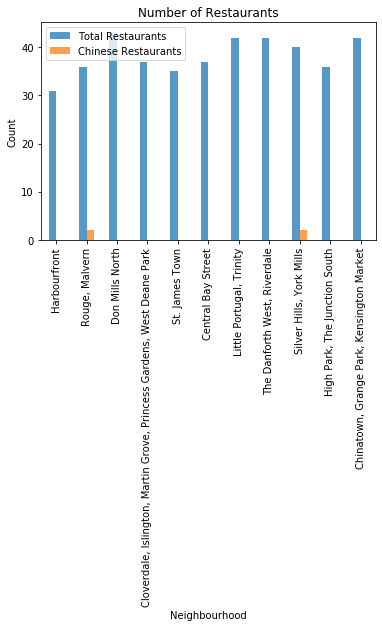

In [65]:
%matplotlib inline

Cl4 = Clusterlabel_4.plot(x='Neighbourhood',y=['Total Restaurants','Chinese Restaurants'],kind='bar',alpha=0.75,title='Number of Restaurants')
Cl4.set_ylabel('Count')

Text(0, 0.5, 'Population')

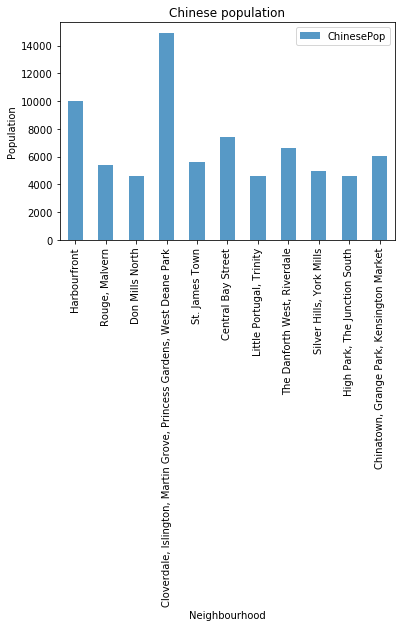

In [66]:
%matplotlib inline

Cl4 = Clusterlabel_4.plot(x='Neighbourhood',y=['ChinesePop'],kind='bar',alpha=0.75,title='Chinese population')
Cl4.set_ylabel('Population')

Text(0, 0.5, 'Population/Area')

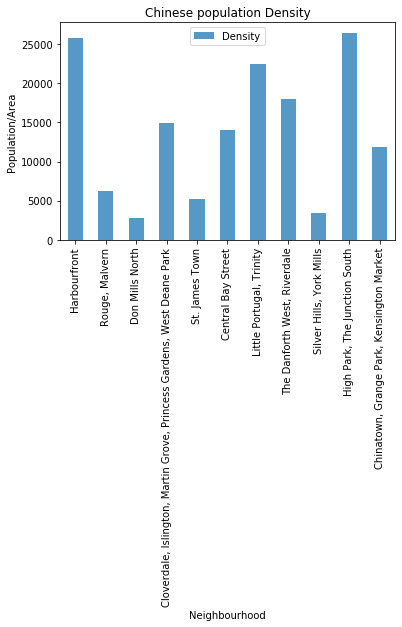

In [67]:
%matplotlib inline

Cl4 = Clusterlabel_4.plot(x='Neighbourhood',y=['Density'],kind='bar',alpha=0.75,title='Chinese population Density')
Cl4.set_ylabel('Population/Area')

#### The above results revealed that large Chinese Population (14921) are living in **Etobicoke**  Borough and **Cloverdale, Islington, Martin Grove, Princess Gardens,West Deane Park** Neighborhood with  density of  14937. The next large  Chinese population of 10000 are living in **Downtown Toronto** Borough and  **Harbourfront** Neighborhood with high density of 25825. The larger density linked with shorter travel distance when the restaurant is opened on the area. There is no Chinese  restaurant at these Borough. Therefore , 1) **Etobicoke**  Borough and **Cloverdale, Islington, Martin Grove, Princess Gardens,West Deane Park**  neighborhood and, 2) **Downtown Toronto** Borough and  **Harbourfront** neighborhood  are recommended as the best place to open Chinese restaurant.